In [9]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
#function to get the cropped image
def get_cropped_img(img_to_crop):
    face_detector=cv2.CascadeClassifier('./opencv/haarcascade_frontalface_default.xml')
    eye_detector = cv2.CascadeClassifier('./opencv/haarcascade_eye.xml')
    img = cv2.imread(img_to_crop)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces_result = face_detector.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces_result:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_detector.detectMultiScale(roi_gray)
        #returns the cropped image if the number of eyes detected is 2
        if len(eyes)>=2:
            return roi_color





In [ ]:
#display cropped image
img = ('./dataset/lionel_messi/5bd946a6cdbadfc416e59db42422c06c.jpg')
plt.imshow(get_cropped_img(img))
plt.show()



In [16]:
#setting path of dataset
path_to_data = "./dataset"
path_to_cr_data = "./dataset/cropped/"


In [17]:
#stores the path of different image directories in a list
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [18]:
img_dirs

['./dataset\\lionel_messi',
 './dataset\\roger_federer',
 './dataset\\virat_kohli']

In [19]:
#creates a directory called cropped. If it already exists, it is removed and is created again
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [20]:
path_to_cr_data

'./dataset/cropped/'

In [21]:
#used to generate and store the cropped images
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split("\\")[-1]
    celebrity_file_names_dict[celebrity_name] = []
    print(celebrity_name)
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_img(entry.path)
        
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder:",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count+=1
        

lionel_messi
Generating cropped images in folder: ./dataset/cropped/lionel_messi
roger_federer
Generating cropped images in folder: ./dataset/cropped/roger_federer
virat_kohli
Generating cropped images in folder: ./dataset/cropped/virat_kohli


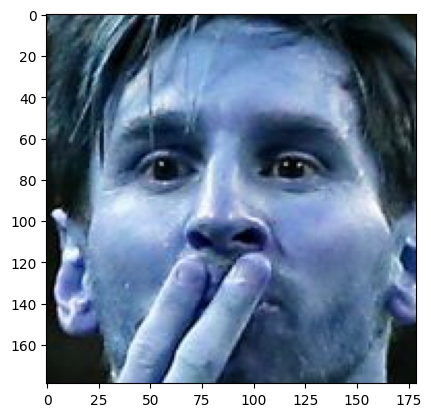

In [22]:
plt.imshow(get_cropped_img("./dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg"))

In [23]:
#used to apply wavelet transform to an image
import numpy as np
import pywt
import cv2

def w2d(img,mode='haar',level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255;
    coeffs = pywt.wavedec2(imArray,mode,level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    imArray_H = pywt.waverec2(coeffs_H,mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)

    return imArray_H

In [24]:
#used to create a dictionary that will have celebrity name as the key and the corresponding image files as list of values
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi\\lionel_messi1.png',
  './dataset/cropped/lionel_messi\\lionel_messi10.png',
  './dataset/cropped/lionel_messi\\lionel_messi11.png',
  './dataset/cropped/lionel_messi\\lionel_messi13.png',
  './dataset/cropped/lionel_messi\\lionel_messi14.png',
  './dataset/cropped/lionel_messi\\lionel_messi15.png',
  './dataset/cropped/lionel_messi\\lionel_messi16.png',
  './dataset/cropped/lionel_messi\\lionel_messi17.png',
  './dataset/cropped/lionel_messi\\lionel_messi18.png',
  './dataset/cropped/lionel_messi\\lionel_messi19.png',
  './dataset/cropped/lionel_messi\\lionel_messi2.png',
  './dataset/cropped/lionel_messi\\lionel_messi20.png',
  './dataset/cropped/lionel_messi\\lionel_messi22.png',
  './dataset/cropped/lionel_messi\\lionel_messi23.png',
  './dataset/cropped/lionel_messi\\lionel_messi24.png',
  './dataset/cropped/lionel_messi\\lionel_messi25.png',
  './dataset/cropped/lionel_messi\\lionel_messi26.png',
  './dataset/cropped/lionel_messi\

In [25]:
#assigns a numerical value to the classes
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0, 'roger_federer': 1, 'virat_kohli': 2}

In [26]:
#used to create the training data by combining the cropped image with its wavelet transform vertically
x = []
y = []

for celebrity_name,training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

In [27]:
#perform wavelet transform for an image
imga = cv2.imread('./dataset/cropped/lionel_messi/lionel_messi1.png')
img_hara = w2d(img,'db1',5)


In [46]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [40]:
len(x[0])

4096

In [41]:
#the feature array is reshaped
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(105, 4096)

In [43]:
#used to fit the training data in svc model
X_train, X_test, Y_train, Y_test = train_test_split(x,y,random_state=0)
X_train
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train, Y_train)
pipe.score(X_test,Y_test)

0.7777777777777778

In [44]:
print(classification_report(Y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.86      0.86      0.86         7
           2       0.62      1.00      0.76         8

    accuracy                           0.78        27
   macro avg       0.82      0.81      0.79        27
weighted avg       0.85      0.78      0.78        27



In [51]:
#different models with some parameters are used to test which model fits best
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [52]:
#here the best estimators are identified
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\uspra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\uspra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\uspra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\uspra\AppData\Local\Programs\Python\P

,model,best_score,best_params
0,svm,0.909167,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.782500,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.935000,{'logisticregression__C': 1}


In [54]:
best_estimators['svm'].score(X_test,Y_test)

0.9629629629629629

In [56]:
best_estimators['random_forest'].score(X_test,Y_test)

0.8888888888888888

In [57]:
best_estimators['logistic_regression'].score(X_test,Y_test)

0.9259259259259259

In [58]:
best_clf = best_estimators['svm']

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, best_clf.predict(X_test))
cm

array([[11,  1,  0],
       [ 0,  7,  0],
       [ 0,  0,  8]])

Text(95.72222222222221, 0.5, 'Truth')

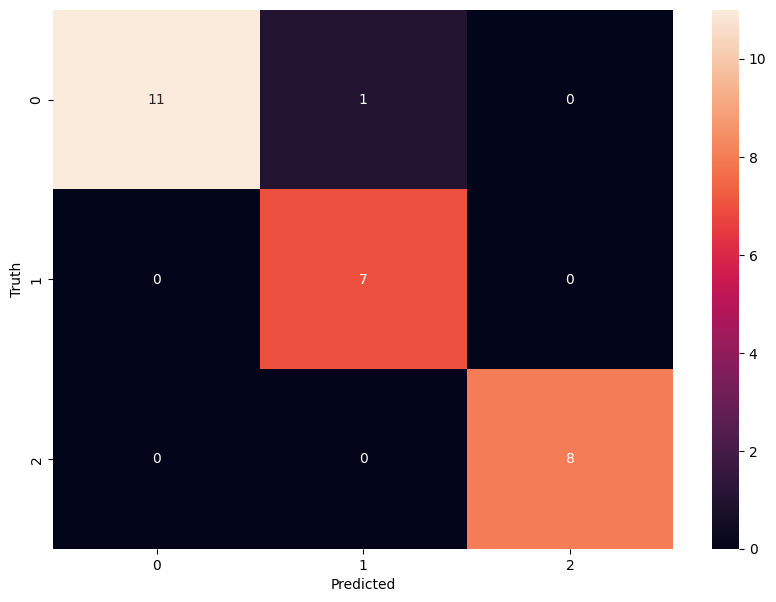

In [61]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
class_dict

{'lionel_messi': 0, 'roger_federer': 1, 'virat_kohli': 2}

In [63]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [64]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [65]:
import joblib
import json

# Load the saved SVM model
model = joblib.load('saved_model.pkl')

# Load the class dictionary
with open('class_dictionary.json', 'r') as f:
    class_dict = json.load(f)
    
# Reverse the class dictionary to map label indices to celebrity names
class_dict_reverse = {v: k for k, v in class_dict.items()}


In [66]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Detect and crop the face
    cropped_face = get_cropped_img(image_path)  # Assuming get_cropped_img is already defined
    
    if cropped_face is None:
        print("No face detected in the image.")
        return None
    
    # Resize the image and wavelet transform it
    scalled_raw_img = cv2.resize(cropped_face, (32, 32))
    img_har = w2d(cropped_face, 'db1', 5)  # Assuming w2d is defined
    scalled_img_har = cv2.resize(img_har, (32, 32))
    
    # Combine both scaled images into a single feature vector
    combined_img = np.vstack((
        scalled_raw_img.reshape(32 * 32 * 3, 1), 
        scalled_img_har.reshape(32 * 32, 1)
    )).reshape(1, 4096).astype(float)
    
    return combined_img


In [67]:
def classify_image(image_path):
    # Preprocess the image
    img_features = preprocess_image(image_path)
    
    if img_features is not None:
        # Make prediction
        prediction = model.predict(img_features)[0]
        
        # Map the predicted label to the celebrity name
        predicted_celebrity = class_dict_reverse[prediction]
        
        print(f"The image is classified as: {predicted_celebrity}")
    else:
        print("Unable to classify image.")


In [74]:
# Example image path for testing
image_path = './dataset/roger_federer/roger-federer-s-daughters-myla-rose-and-charlene-riva-turn-9.jpg'

# Classify the image
classify_image(image_path)


The image is classified as: roger_federer
